In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../codes')

import pickle
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

from utils.img_utils import hsv_hist, lbp_hist

In [3]:
sns.set_context('paper', font_scale=1.5, 
                rc={'lines.linewidth': 2,
                    'text.usetex' : True,
                    'image.interpolation': 'nearest',
                    'image.cmap': 'gray',
                    'figure.figsize': (10.0, 8.0)})
sns.set_style(style='white')
sns.set_palette('colorblind', color_codes=True)

In [4]:
# util functions
def read_img(filepath):
    img = cv2.imread(filepath).astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
    return img

def resize(img, scale):
    width = int(mask.shape[1] * scale)
    height = int(mask.shape[0] * scale)

    dsize = (width, height)
    
    return cv2.resize(img, dsize)

# compute features
def compute_feature_vector(img, mask=None):
    hist_h, hist_s, hist_v = hsv_hist(img, weights=mask)   
    hist_lbp = lbp_hist(img, weights=mask)
    
    return np.concatenate((hist_h, hist_s, hist_v, hist_lbp))

def get_bbox_from_mask(mask):
    rows, cols, _ = np.where(mask==1)
    
    xmin = cols.min()
    xmax = cols.max()

    ymin = rows.min()
    ymax = rows.max()
    
    return xmin, ymin, xmax, ymax

def get_obj_size(bbox):
    x = bbox[2] - bbox[0]
    y = bbox[3] - bbox[1]
    
    return x,y

def compute_bbox_area(bbox):
    x ,y = get_obj_size(bbox)
    
    return x*y    

def get_img_name_by_ind(iterable, ind):
    n = 0
    for frame_name in iterable.keys():               
        if n == ind: break
        n += 1  
    return frame_name    

In [5]:
def get_feats(img_dir, mask_dir=None, feats_path=None):
    
    # path to load/save features
    # if none, load/save in img_dir
    if feats_path is None:
        feats_path = os.path.join(img_dir, 'feats.pkl')
    
    # if features already computed, just load it
    if os.path.exists(feats_path):
        f = open(feats_path,"rb")
        feats = pickle.load(f)
        f.close()
        
        return feats        
    
    # otherwise, compute and save
    feats = dict()
    mask = None
    
    for dirpath, dirname, filenames in tqdm(os.walk(img_dir)):
        if len(filenames) == 0:
                continue
        
        for filename in tqdm(filenames, total=len(filenames)):            
            if not filename.endswith('.png'):
                continue
                        
            obj = read_img(os.path.join(img_dir, filename))
            
            if mask_dir is not None:
                mask = read_img(os.path.join(mask_dir, filename))
                
            img_name = filename.split('.')[0]        
            feats[img_name] = compute_feature_vector(obj, mask)  
            
    f = open(feats_path,"wb")
    pickle.dump(feats,f)
    f.close()
            
    
    return feats

In [6]:
def get_all_bkg_feats(root_dir):

    feats_bkg = dict()

    for dirpath, dirname, filenames in tqdm(os.walk(root_dir)):
        if len(filenames) == 0:
            continue

        video_name = dirpath.split('/')[-1]
        feats_bkg[video_name] = get_feats(dirpath)

    return feats_bkg

In [7]:
obj = read_img('../data/tires_fake/tire-0011.png')
mask = read_img('../data/masks_fake/tire-0011.png')
masked_obj = obj*mask

xmin, ymin, xmax, ymax = get_bbox_from_mask(mask)
print(compute_bbox_area((xmin, ymin, xmax, ymax)))
masked_obj_bbox = cv2.rectangle(masked_obj.copy(), (xmin, ymin), (xmax, ymax), (0,255,0), 20) 

6927708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


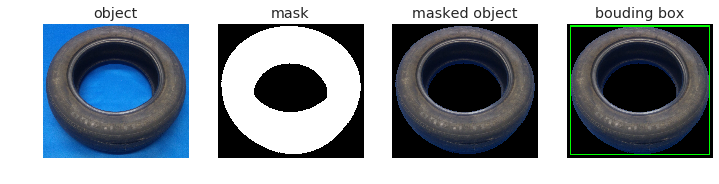

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(1,4,1)
plt.imshow(obj)
plt.title('object')
plt.axis('off')


plt.subplot(1,4,2)
plt.imshow(mask)
plt.title('mask')
plt.axis('off')


plt.subplot(1,4,3)
plt.imshow(masked_obj)
plt.title('masked object')
plt.axis('off')


plt.subplot(1,4,4)
plt.imshow(masked_obj_bbox)
plt.title('bouding box')
plt.axis('off')

plt.show()

In [9]:
bianca_feats_d = get_feats('../data/biancaTires', '../data/biancaMasks')
fake_feats_d = get_feats('../data/tires_fake', '../data/masks_fake')

bianca_feats = np.array([v for v in bianca_feats_d.values() ])
fake_feats = np.array([v for v in fake_feats_d.values() ])

In [10]:
# bkg_feats = get_all_bkg_feats('../data/_under_construction/Train')

videos = [
    '20180919_rectfied_DJI_0018',
    '20181022_rectfied_DJI_0025',
    '20181029_rectfied_DJI_0033',
    '20181029_rectfied_DJI_0034',
    '20190601_rectfied_DJI_0003',
    '20190601_rectfied_DJI_0006',
]
bkg_feats = {video: get_feats(f'../data/_under_construction/Train/{video}') for video in videos}

In [11]:
def knn(vid, metric='cosine'):
    samples = np.array([v for v in bkg_feats[vid].values()])

    N_NEIGHBORS = len(samples)
    METRIC_KNN = metric #Cosine distance is defined as 1.0 minus the cosine similarity.

    nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS, metric=METRIC_KNN,
                            algorithm='auto', n_jobs=-1)
    return nbrs.fit(samples)
    

In [12]:
nbrs = {vid: knn(vid, metric='cosine') for vid in videos}

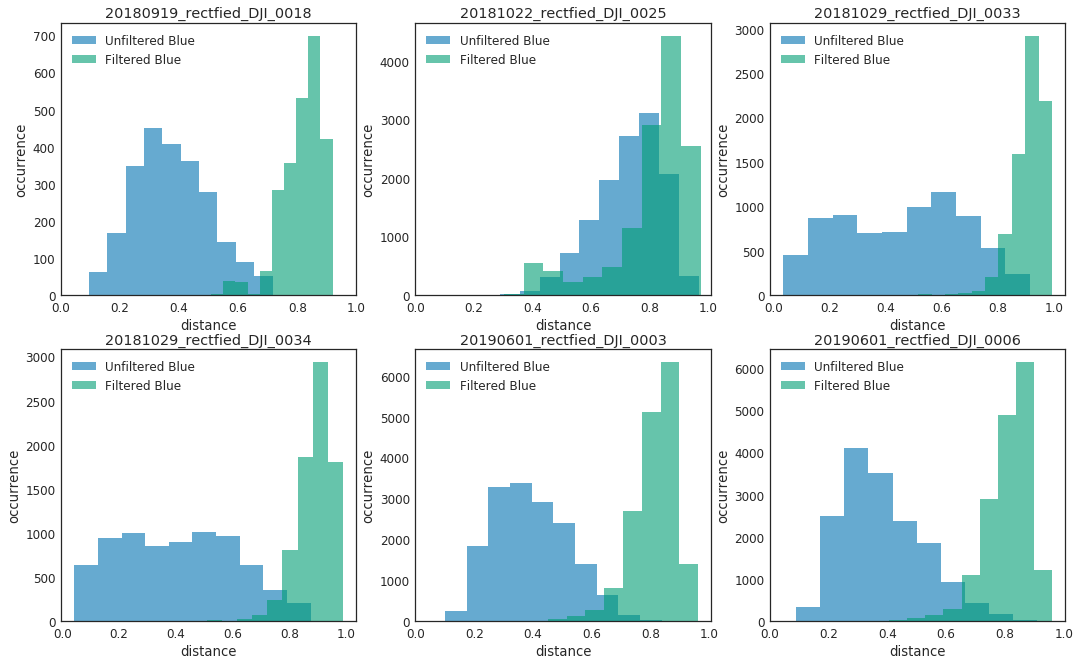

In [13]:
distances_b = dict()
distances_f = dict()
indices_b = dict()
indices_f = dict()

plt.figure(figsize=(18,11))

for n, video in enumerate(videos):
    
    distances_b[video], indices_b[video] = nbrs[video].kneighbors(bianca_feats)
    distances_f[video], indices_f[video] = nbrs[video].kneighbors(fake_feats)
    
    plt.subplot(2,3,n+1)
    
    plt.hist(np.concatenate(distances_f[video]), alpha=0.6)
    plt.hist(np.concatenate(distances_b[video]), alpha=0.6)
    
    
    plt.title(video)

    plt.xlabel('distance')
    plt.ylabel('occurrence')
    plt.xticks(np.arange(0, 1.2, step=0.2))
    
    plt.legend(['Unfiltered Blue', 'Filtered Blue'], loc='upper left')
plt.show()

frame_1110


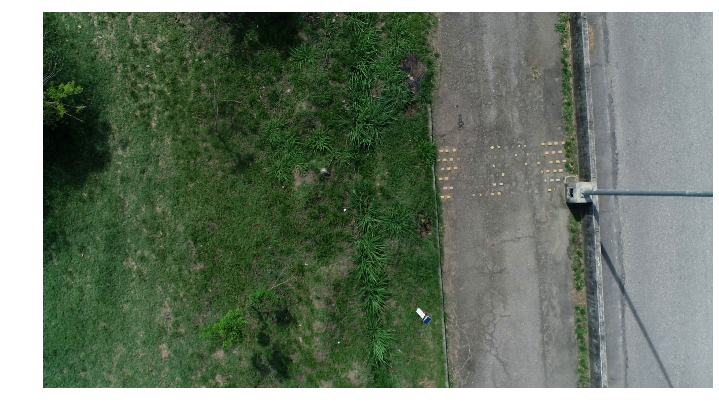

In [14]:
vid =  '20180919_rectfied_DJI_0018'

frame_name = get_img_name_by_ind(bkg_feats[vid], indices_f[vid][0,0])
bg = read_img(os.path.join(f'../data/_under_construction/Train/{vid}', frame_name+ '.png'))
print(frame_name)

plt.figure(figsize=(12,10))
plt.imshow(bg)
plt.axis('off')
plt.show()

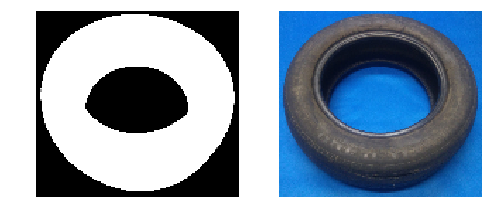

(132, 144, 3) (132, 144, 3)


In [15]:
scale = 0.05
resized_mask = resize(mask, scale)
resized_obj = resize(obj, scale)

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(resized_mask)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(resized_obj)
plt.axis('off')
plt.show()

print(resized_mask.shape, resized_obj.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


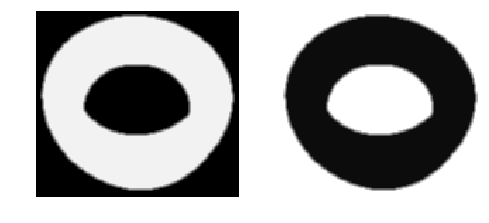

In [16]:
kernel_erode = np.ones((3, 3), np.uint8)
resized_mask_erode = cv2.erode(
                        resized_mask, kernel_erode, iterations=1)

blur = cv2.blur(resized_mask_erode, (3, 3))
# blur = cv2.GaussianBlur(resized_mask_erode,(7,7),5)

blur *= 0.95

inv_blur = 1 - blur

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(blur)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(inv_blur)
plt.axis('off')
plt.show()

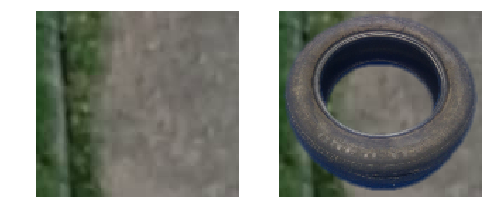

In [17]:
start_point = (1250, 2250)
patch_bg = bg[start_point[0]: start_point[0] + resized_obj.shape[0], \
              start_point[1]: start_point[1] + resized_obj.shape[1]].copy()

new_patch = blur * resized_obj + inv_blur * patch_bg

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(patch_bg)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(new_patch)
plt.axis('off')
plt.show()

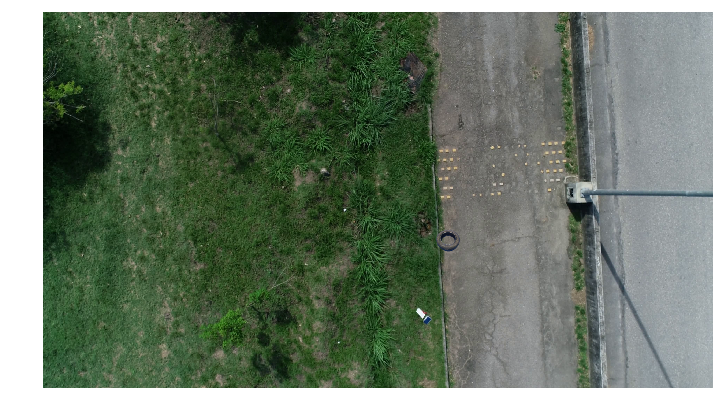

In [18]:
new_img = bg.copy()
new_img[start_point[0]: start_point[0] + resized_obj.shape[0], \
              start_point[1]: start_point[1] + resized_obj.shape[1]] = new_patch

plt.figure(figsize=(12,8))
plt.imshow(new_img)
plt.axis('off')

plt.show()

In [19]:
def merge(bg, obj, mask, start_point, obj_rescale=0.05, alpha=0.95):
    
    resized_mask = resize(mask, obj_rescale)
    resized_obj = resize(obj, obj_rescale)
    
    kernel_erode = np.ones((3, 3), np.uint8)
    resized_mask_erode = cv2.erode(resized_mask, kernel_erode, iterations=1)
    
    blur = cv2.blur(resized_mask_erode, (3, 3))
    # blur = cv2.GaussianBlur(resized_mask_erode,(7,7),5)
        
    blur *= alpha
    inv_blur = 1 - blur
    
    patch_bg = bg[start_point[0]: start_point[0] + resized_obj.shape[0], \
              start_point[1]: start_point[1] + resized_obj.shape[1]].copy()

    new_patch = blur * resized_obj + inv_blur * patch_bg
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    plt.imshow(patch_bg)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(new_patch)
    plt.axis('off')
    plt.show()
    
    new_img = bg.copy()
    new_img[start_point[0]: start_point[0] + resized_obj.shape[0], \
              start_point[1]: start_point[1] + resized_obj.shape[1]] = new_patch

    return new_img 

8
frame_3390
tire-0034


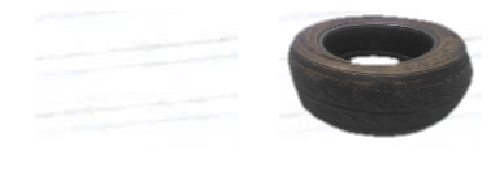

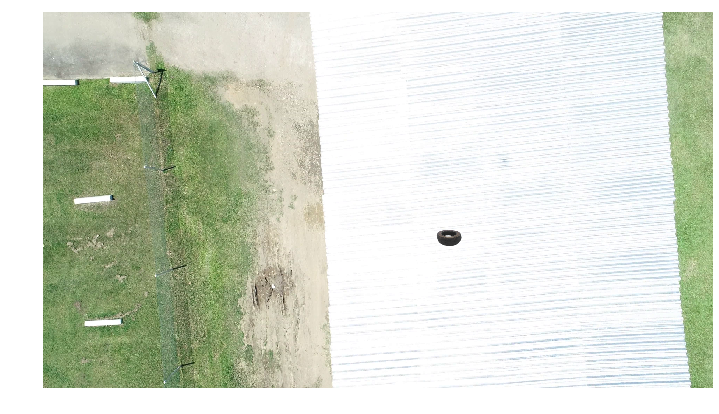

In [20]:
# get background
vid =  '20181022_rectfied_DJI_0025'
mask_fold = 'biancaMasks'
obj_fold = 'biancaTires'
feats = bianca_feats_d
indice = indices_b[vid][13,0]
print(indice)

frame_name = get_img_name_by_ind(bkg_feats[vid], indice)
bg = read_img(os.path.join(f'../data/_under_construction/Train/{vid}', frame_name+ '.png'))
print(frame_name)

# get object and mask
obj_name = get_img_name_by_ind(feats, indice)
obj = read_img(f'../data/{obj_fold}/{obj_name}.png')
mask = read_img(f'../data/{mask_fold}/{obj_name}.png')
print(obj_name)

start_point = (1250, 2250)
merged_img = merge(bg, obj, mask, start_point, obj_rescale=0.05, alpha=0.95)

plt.figure(figsize=(12,8))
plt.imshow(merged_img)
plt.axis('off')

plt.show()

In [21]:
cv2.imwrite('test2.jpg', cv2.cvtColor(merged_img, cv2.COLOR_RGB2BGR)*255)

True